# Working with NetCDF data in R

This notebook will show how to open some geospatial data stored in a NetCDF file. Specifically, we will select the variable and time range of interest, and we will export the data to a GeoTIFF so that we can continue the analysis in R or other geospatial software.

First, we need some data to play with. As an example, we will use a NetCDF file related to the near-surface (usually, 2 meter) air temperature (**tas**) from the **historical** experiment of the **CMCC-ESM2** model.

    home/jovyan/data/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/Amon/tas/gn/v20210114/tas_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc

## Load the required R packages

In [21]:
library(ncdf4) # package for netcdf manipulation
library(raster) # package for raster manipulation
library(rgdal) # package for geospatial analysis
library(ggplot2) # package for plotting
library(fs) # package for file manipulations

## Read in the NetCDF file content

Use **nc_open** to read the data into a data structure called *nc_data*, then print the metadata about this file.

In [2]:
nc_file_path = '/home/jovyan/data/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/Amon/tas/gn/v20210114/tas_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc'

nc_data <- nc_open(nc_file_path)

print(nc_data)

File /home/jovyan/data/CMIP6/CMIP/CMCC/CMCC-ESM2/historical/r1i1p1f1/Amon/tas/gn/v20210114/tas_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc (NC_FORMAT_NETCDF4_CLASSIC):

     5 variables (excluding dimension variables):
        double time_bnds[bnds,time]   (Chunking: [2,1])  (Compression: shuffle,level 3)
        double lat_bnds[bnds,lat]   (Chunking: [2,192])  (Compression: shuffle,level 3)
        double lon_bnds[bnds,lon]   (Chunking: [2,288])  (Compression: shuffle,level 3)
        double height[]   (Contiguous storage)  
            units: m
            axis: Z
            positive: up
            long_name: height
            standard_name: height
        float tas[lon,lat,time]   (Chunking: [288,192,1])  (Compression: shuffle,level 3)
            standard_name: air_temperature
            long_name: Near-Surface Air Temperature
            comment: near-surface (usually, 2 meter) air temperature
            units: K
            original_name: TREFHT
            cell_m

The output above shows that there are 
- five variables:
  - time_bnds: the start and end time of each observation
  - lat_bnds: latitude boundary coordinates
  - lon_bnds: longitude boundary coordinates
  - height: height coordinate
  - tas: the variable of interest, defined over three dimensions: [lon,lat,time].

- four dimensions: lat, lon, time, bnds
  
There are 48 global attributes,  which provide metadata information about the file.

The following code reads the latitude, longitude, and time of each *tas* observation and saves them in memory.

In [3]:
lon <- ncvar_get(nc_data, "lon")
lat <- ncvar_get(nc_data, "lat", verbose = F)
t <- ncvar_get(nc_data, "time")

Read in the data from the *tas* variable and verify the size of the array. There should be 288 lons, 192 lats, and 1980 times (monthly data from 1850 to 2014)

In [4]:
tas.array <- ncvar_get(nc_data, "tas") # store the data in a 3-dimensional array
dim(tas.array) 

[1]  288  192 1980

Another useful information about the *tas* variable is about the fill value used for missing data.

In [5]:
fillvalue <- ncatt_get(nc_data, "tas", "_FillValue")
fillvalue

$hasatt
[1] TRUE

$value
[1] 1e+20

When we are done reading in the data, we can close the NetCDF file.

In [6]:
nc_close(nc_data) 

## Working with the data

Now we have the entire array of *tas* values for 288 x 192 grid cells over each of 165 years in R. What can we do with it?

First, we can replace all the fill values with the R-standard ‘NA’.

In [7]:
tas.array[tas.array == fillvalue$value] <- NA

Now, let’s plot some data on a map, for example the near-surface air temperature for one of the timesteps over the whole spatial domain.

 - Time is the third dimension of the *tas.array*.
 - The time span is between 1850 to 2014.
 - The time resolution is monthly.

So, we can get the first time slice, which represents **January, 1850**

In [8]:
tas.slice <- tas.array[, , 1] 

To make sure everything is working correctly, we can take a look at the dimensions of this time slice. The dimensions should be 288 longitudes by 192 latitudes.

In [9]:
dim(tas.slice)

[1] 288 192

We can now save this data in a raster. 

The CRS (Coordinate Reference System) is provided in the standard well-known text format. For this data set, we set it to the common WGS84 system.

In [10]:
r <- raster(t(tas.slice), xmn=min(lon), xmx=max(lon), ymn=min(lat), ymx=max(lat), crs=CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs+ towgs84=0,0,0"))

Before plotting the data, we need to transpose and flip to orient the data correctly.

In [11]:
r <- flip(r, direction='y')

## Plotting

Finally, we can plot the raster to take a look at the *tas* in January, 1850.

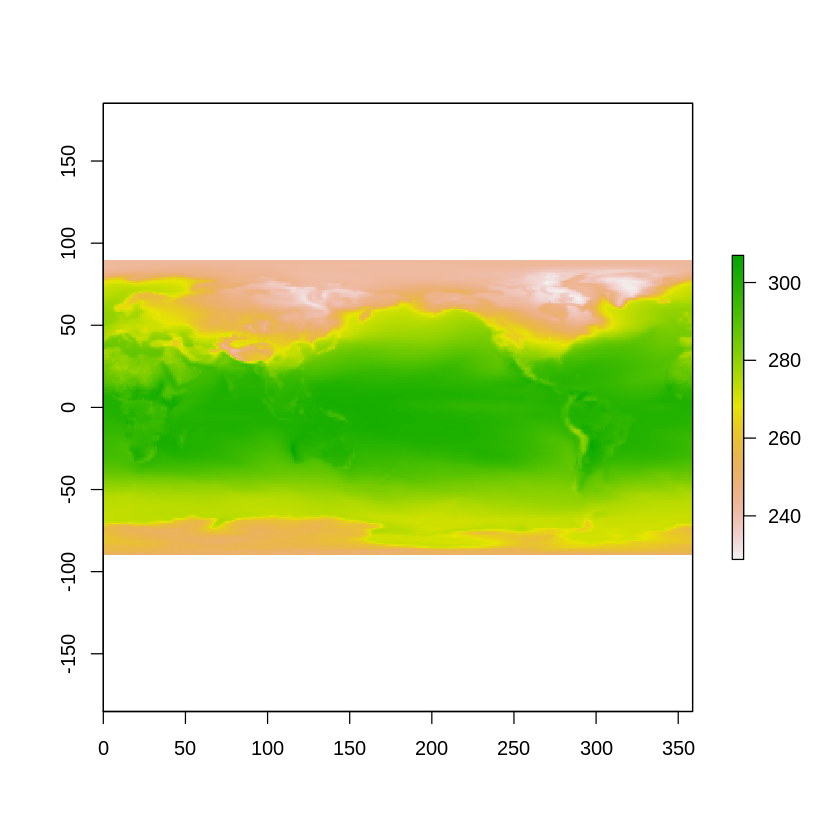

In [12]:
plot(r)

## Saving to a GeoTIFF

Let’s save it to a GeoTIFF file.

In [73]:
home = path_expand("~")
writeRaster(r, home+'/work/tas_January_1850.tif', "GTiff", overwrite=TRUE)

## Difference in tas between two time periods

Let’s look at the difference in *tas* between January, 1851 and January, 1850.

We already have data from January, 1850 (*tas.slice* array).Let’s get the data from January, 1851 (the 12th time slice)

In [15]:
tas.slice.January.1851 <- tas.array[, , 13] 

Now take the difference between them.

In [17]:
tas.diff <- tas.slice.January.1851 - tas.slice

Save the difference map as a raster.

In [18]:
r_diff <- raster(t(tas.diff), xmn=min(lon), xmx=max(lon), ymn=min(lat), ymx=max(lat), crs=CRS("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs+ towgs84=0,0,0"))


Re-orient the data for geotiff.

In [19]:
r_diff <- flip(r_diff, direction='y')

And plot.

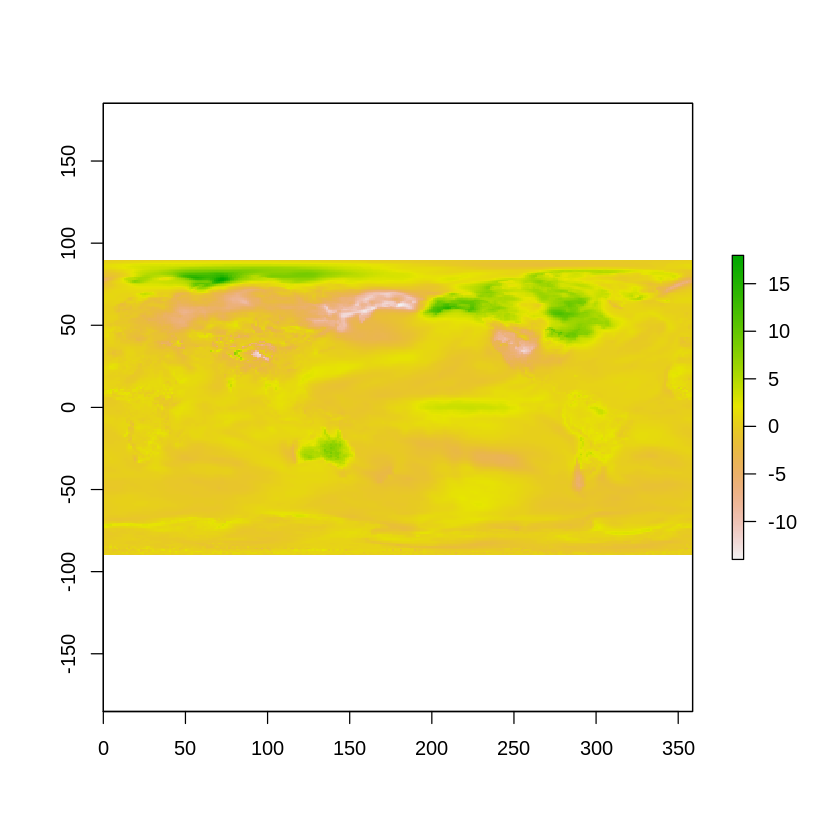

In [20]:
plot(r_diff)